In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import os
import matplotlib.colors as clrs
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.feature_selection import SelectKBest, f_classif

fp_ds1 = "./heart_failure_clinical_records_dataset.csv"
fp_ds2 = "./qsar_oral_toxicity.csv"
ds1 = pd.read_csv(fp_ds1, parse_dates=False, sep=',')
ds2 = pd.read_csv(fp_ds2, parse_dates=False, sep=';')
my_palette = {'yellow': '#ECD474', 'pale orange': '#E9AE4E', 'salmon': '#E2A36B', 'orange': '#F79522', 'dark orange': '#D7725E',
              'pale acqua': '#92C4AF', 'acqua': '#64B29E', 'marine': '#3D9EA9', 'green': '#10A48A', 'olive': '#99C244',
              'pale blue': '#BDDDE0', 'blue2': '#199ED5', 'blue3': '#1DAFE5', 'dark blue': '#0C70B2',
              'pale pink': '#D077AC', 'pink': '#EA4799', 'lavender': '#E09FD5', 'lilac': '#B081B9', 'purple': '#923E97',
              'white': '#FFFFFF', 'light grey': '#D2D3D4', 'grey': '#939598', 'black': '#000000'}

In [26]:
import datetime as dt

NR_COLUMNS: int = 3
HEIGHT: int = 4


def choose_grid(nr):
    if nr < NR_COLUMNS:
        return 1, nr
    else:
        return (nr // NR_COLUMNS, NR_COLUMNS) if nr % NR_COLUMNS == 0 else (nr // NR_COLUMNS + 1, NR_COLUMNS)


def set_axes(xvalues: list, ax: plt.Axes = None, title: str = '', xlabel: str = '', ylabel: str = '', percentage=False):
    if ax is None:
        ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(xvalues, fontsize='small', ha='center')

    return ax


def set_locators(xvalues: list, ax: plt.Axes = None):
    if isinstance(xvalues[0], dt.datetime):
        locator = mdates.AutoDateLocator()
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator, defaultfmt='%Y-%m-%d'))
    else:
        ax.set_xticks(xvalues)
        ax.set_xlim(xvalues[0], xvalues[-1])

    return ax


def plot_line(xvalues: list, yvalues: list, ax: plt.Axes = None, title: str = '', xlabel: str = '',
              ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)
    ax = set_locators(xvalues, ax=ax)
    ax.plot(xvalues,  yvalues, c=cfg.LINE_COLOR)


def multiple_line_chart(xvalues: list, yvalues: dict, ax: plt.Axes = None, title: str = '',
                        xlabel: str = '', ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)
    ax = set_locators(xvalues, ax=ax)

    legend: list = []
    for name, y in yvalues.items():
        ax.plot(xvalues, y)
        legend.append(name)
    ax.legend(legend)


def bar_chart(xvalues: list, yvalues: list, ax: plt.Axes = None, title: str = '',
              xlabel: str = '', ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)
    ax.bar(xvalues, yvalues, edgecolor=my_palette['dark blue'], color=my_palette['pale blue'])


def multiple_bar_chart(xvalues: list, yvalues: dict, ax: plt.Axes = None, title: str = '',
                       xlabel: str = '', ylabel: str = '', percentage=False):
    ax = set_axes(xvalues, ax=ax, title=title, xlabel=xlabel, ylabel=ylabel, percentage=percentage)

    x = np.arange(len(xvalues))  # the label locations

    width = 0.8 / (len(xvalues)*len(yvalues))
    # the width of the bars
    step = width / len(xvalues)
    i: int = 0
    for metric in yvalues:
        ax.bar(x + i*width, yvalues[metric], width=width, align='center', label=metric)
        i += 1
    ax.set_xticks(x + width/len(xvalues) - step/2)
    ax.legend(fontsize='x-small', title_fontsize='small')


def plot_confusion_matrix(cnf_matrix: np.ndarray, classes_names: np.ndarray,
                          ax: plt.Axes = None, normalize: bool = False):
    if ax is None:
        ax = plt.gca()
    if normalize:
        total = cnf_matrix.sum(axis=1)[:, np.newaxis]
        cm = cnf_matrix.astype('float') / total
        title = "Normalized confusion matrix"
    else:
        cm = cnf_matrix
        title = 'Confusion matrix'
    np.set_printoptions(precision=2)
    tick_marks = np.arange(0, len(classes_names), 1)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes_names)
    ax.set_yticklabels(classes_names)
    ax.imshow(cm, interpolation='nearest', cmap=clrs.LinearSegmentedColormap.from_list("myCMPBlues", [my_palette['pale blue'], my_palette['blue2'], my_palette['blue3'], my_palette['dark blue']]))

    fmt = '.2f' if normalize else 'd'
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt), color='w', horizontalalignment="center")


def plot_evaluation_results(labels: np.ndarray, trn_y, prd_trn, tst_y, prd_tst):
    cnf_mtx_trn = metrics.confusion_matrix(trn_y, prd_trn, labels)
    tn_trn, fp_trn, fn_trn, tp_trn = cnf_mtx_trn.ravel()
    cnf_mtx_tst = metrics.confusion_matrix(tst_y, prd_tst, labels)
    tn_tst, fp_tst, fn_tst, tp_tst = cnf_mtx_tst.ravel()

    evaluation = {'Accuracy': [(tn_trn + tp_trn) / (tn_trn + tp_trn + fp_trn + fn_trn),
                               (tn_tst + tp_tst) / (tn_tst + tp_tst + fp_tst + fn_tst)],
                  'Recall': [tp_trn / (tp_trn + fn_trn), tp_tst / (tp_tst + fn_tst)],
                  'Specificity': [tn_trn / (tn_trn + fp_trn), tn_tst / (tn_tst + fp_tst)],
                  'Precision': [tp_trn / (tp_trn + fp_trn), tp_tst / (tp_tst + fp_tst)]}

    fig, axs = plt.subplots(1, 2, figsize=(2 * HEIGHT, HEIGHT))
    multiple_bar_chart(['Train', 'Test'], evaluation, ax=axs[0], title="Model's performance over Train and Test sets")
    plot_confusion_matrix(cnf_mtx_tst, labels, ax=axs[1])


def plot_roc_chart(models: dict, tstX: np.ndarray, tstY: np.ndarray, ax: plt.Axes = None, target: str = 'class'):
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel('FP rate')
    ax.set_ylabel('TP rate')
    ax.set_title('ROC chart for %s' % target)

    ax.plot([0, 1], [0, 1], color='navy', label='random', linewidth=1, linestyle='--',  marker='')
    for clf in models.keys():
        metrics.plot_roc_curve(models[clf], tstX, tstY, ax=ax, marker='', linewidth=1)
    ax.legend(loc="lower right")

In [27]:
x_data = ds1.drop("DEATH_EVENT",axis=1) # It is our x axis data (not normalized)
x = (x_data - np.min(x_data))/(np.max(x_data)-np.min(x_data))
x.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,0.636364,0.0,0.071319,0.0,0.090909,1.0,0.290823,0.157303,0.485714,1.0,0.0,0.000000
1,0.272727,0.0,1.000000,0.0,0.363636,0.0,0.288833,0.067416,0.657143,1.0,0.0,0.007117
2,0.454545,0.0,0.015693,0.0,0.090909,0.0,0.165960,0.089888,0.457143,1.0,1.0,0.010676
3,0.181818,1.0,0.011227,0.0,0.090909,0.0,0.224148,0.157303,0.685714,1.0,0.0,0.010676
4,0.454545,1.0,0.017479,1.0,0.090909,0.0,0.365984,0.247191,0.085714,0.0,0.0,0.014235


/home/aid/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


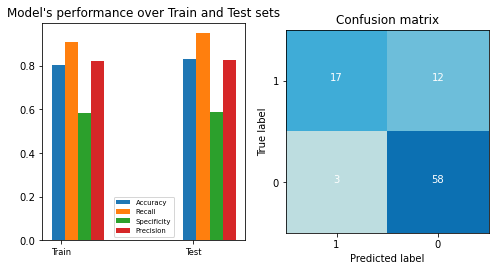

In [28]:
numerical_features = ['age', 'ejection_fraction','serum_creatinine', 'serum_sodium', 'time']
data: pd.DataFrame = pd.read_csv(fp_ds1)
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = x[numerical_features].values
#correlaçao quase direta com feature e target. O target pode ser feito com um conjunto de features  que não estas
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
#fazer cross validation em vez de 70/30. QUando está balanced é mais facil fazer stratify

clf = GaussianNB()
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)


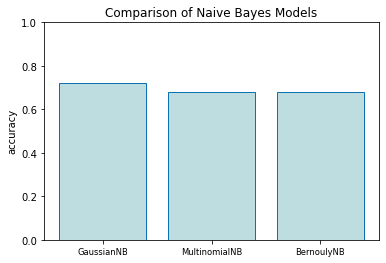

In [25]:
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulyNB': BernoulliNB()}

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(trnX, trnY)
    prdY = estimators[clf].predict(tstX)
    yvalues.append(metrics.accuracy_score(tstY, prdY))

plt.figure()
bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.show()

In [18]:
numerical_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction',
                      'platelets', 'serum_creatinine', 'serum_sodium',
                      'time', 'anaemia', 'diabetes', 'high_blood_pressure',
                        'sex', 'smoking']

numerical_selector = SelectKBest(f_classif,  k=5)
X_numerical = numerical_selector.fit_transform(ds1[numerical_features], 
                                                  ds1['DEATH_EVENT'])

print('Numerical features selected:', data[numerical_features].columns[numerical_selector.get_support()].to_list())

Numerical features selected: ['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']


In [19]:
y = ds1['DEATH_EVENT']
X_sel = ds1[['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']]

X_train, X_test, y_train, y_test = train_test_split(X_sel, y, 
                                                    test_size = 0.2, 
                                                    stratify = y)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

knn_parameters = {'n_neighbors' : [i for i in range(1, 40)]}

grid_search_knn = GridSearchCV(estimator = KNeighborsClassifier(), 
                           param_grid = knn_parameters,
                           cv = 10,
                           n_jobs = -1)

grid_search_knn.fit(X_train_scaled, y_train)

knn = grid_search_knn.best_estimator_

y_pred_knn = knn.predict(X_test_scaled)

knn_accuracy = accuracy_score(y_test, y_pred_knn)

knn_cv_score = cross_val_score(knn, X_sel, y, cv=10).mean()

print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        41
           1       0.59      0.53      0.56        19

    accuracy                           0.73        60
   macro avg       0.69      0.68      0.68        60
weighted avg       0.73      0.73      0.73        60



In [8]:
sb_vars = ds1.select_dtypes(include='object')
ds1[sb_vars.columns] = ds1.select_dtypes(['object']).apply(lambda x: x.astype('category'))

cols_nr = ds1.select_dtypes(include='number')
cols_sb = ds1.select_dtypes(include='category')

ds1.describe(include='all')

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [9]:
corr = ds1.corr()
cor = corr[abs(corr['DEATH_EVENT']) > 0.1]['DEATH_EVENT']
cor

age                  0.253729
ejection_fraction   -0.268603
serum_creatinine     0.294278
serum_sodium        -0.195204
time                -0.526964
DEATH_EVENT          1.000000
Name: DEATH_EVENT, dtype: float64

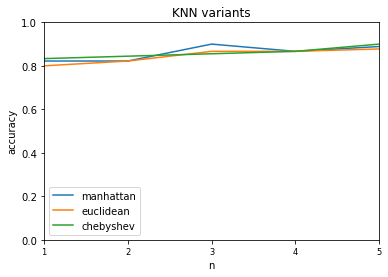

Best results with 3 neighbors and manhattan


In [10]:
numerical_features = ['age', 'ejection_fraction','serum_creatinine', 'serum_sodium', 'time']

data: pd.DataFrame = pd.read_csv(fp_ds1)
y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data[numerical_features].values
labels = pd.unique(y)

trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)

nvalues = [1,2,3,4,5] #isto não faz sentido
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
best = (0, '')
last_best = 0
for d in dist:
    yvalues = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        yvalues.append(metrics.accuracy_score(tstY, prdY))
        if yvalues[-1] > last_best:
            best = (n, d)
            last_best = yvalues[-1]
    values[d] = yvalues

plt.figure()
multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

/home/aid/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


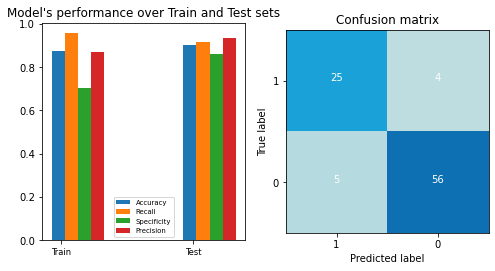

In [11]:
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
plot_evaluation_results(pd.unique(y), trnY, prd_trn, tstY, prd_tst)

/home/aid/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=[1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


<Figure size 432x288 with 0 Axes>

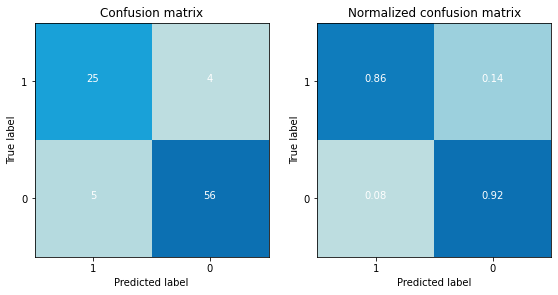

In [12]:
labels: np.ndarray = pd.unique(y)
prdY: np.ndarray = clf.predict(tstX)
cnf_mtx: np.ndarray = metrics.confusion_matrix(tstY, prdY, labels)
plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(8, 4), squeeze=False)
plot_confusion_matrix(cnf_mtx, labels, ax=axs[0,0])
plot_confusion_matrix(metrics.confusion_matrix(tstY, prdY, labels), labels, axs[0,1], normalize=True)
plt.tight_layout()
plt.show()